
# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Подгружаем нужные библиотеки и импортируем их

In [6]:
!pip install -q --upgrade keras-nlp tensorflow
!pip install -q sentence-transformers

In [7]:
!pip install -q --upgrade keras tensorflow 

In [8]:
pip install -q  transformers

Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install -q opencv-python

In [10]:
import pickle
import re
from collections import Counter
from os.path import exists, isfile, join
import os
import seaborn as sns
from sklearn.metrics import accuracy_score
from tqdm import notebook
from tqdm.notebook import tqdm
from pathlib import Path
import nltk
import cv2
nltk.download('punkt')
nltk.download('wordnet')
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from ipywidgets import IntProgress
from matplotlib import pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
import keras
import keras_nlp
from keras.models import Sequential
from keras.layers import Dense, Activation
from transformers import BertModel, BertTokenizer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.applications.resnet import (
    ResNet50,
    decode_predictions,
    preprocess_input,
)
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm, trange


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anon9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anon9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Задаем переменные и указываем путь к нашим данным, так же пишем слова , фотографии с которыми будем убирать из-за юр. проблем

In [6]:
PATH = 'C://Users/anon9/Desktop/to_upload/'
SEED = 12345
BAN = ['child', 'boy', 'girl', 'baby', 'teenager', 'kid','kids', 'children', 'boys', 'girls', 'babies', 'teens']

np.random.seed(SEED)
tf.random.set_seed(SEED)

Создаем функцию для прочтения данных

In [7]:
def read_df(path=PATH) -> pd.DataFrame:

    
    df_train = pd.read_csv(Path(path, 'train_dataset.csv'))
    df_crowd = pd.read_csv(Path(path, 'CrowdAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    df_expert = pd.read_csv(Path(path, 'ExpertAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'first', 'second', 'third'])
    df_queries = pd.read_csv(Path(path, 'test_queries.csv'), index_col=[0], sep='|')
    df_images = pd.read_csv(Path(path, 'test_images.csv'), sep='|')
    
    return df_train, df_crowd, df_expert, df_queries, df_images

df_train, df_crowd, df_expert, df_queries, df_images = read_df()

Познакомимся с данными

In [8]:
df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [9]:
df_train.duplicated().sum()

0

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [11]:
df_crowd.head()

image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3  
3          0          3  
4          0          3

In [12]:
df_crowd.duplicated().sum()

0

In [13]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   count_pos  47830 non-null  int64  
 4   count_neg  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [14]:
df_expert.head()

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

In [15]:
df_expert.duplicated().sum()

0

In [16]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [17]:
df_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [18]:
df_queries.duplicated().sum()

0

In [19]:
df_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [20]:
df_images.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [21]:
df_images.duplicated().sum()

0

In [22]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


Посмотрим на фото из файла

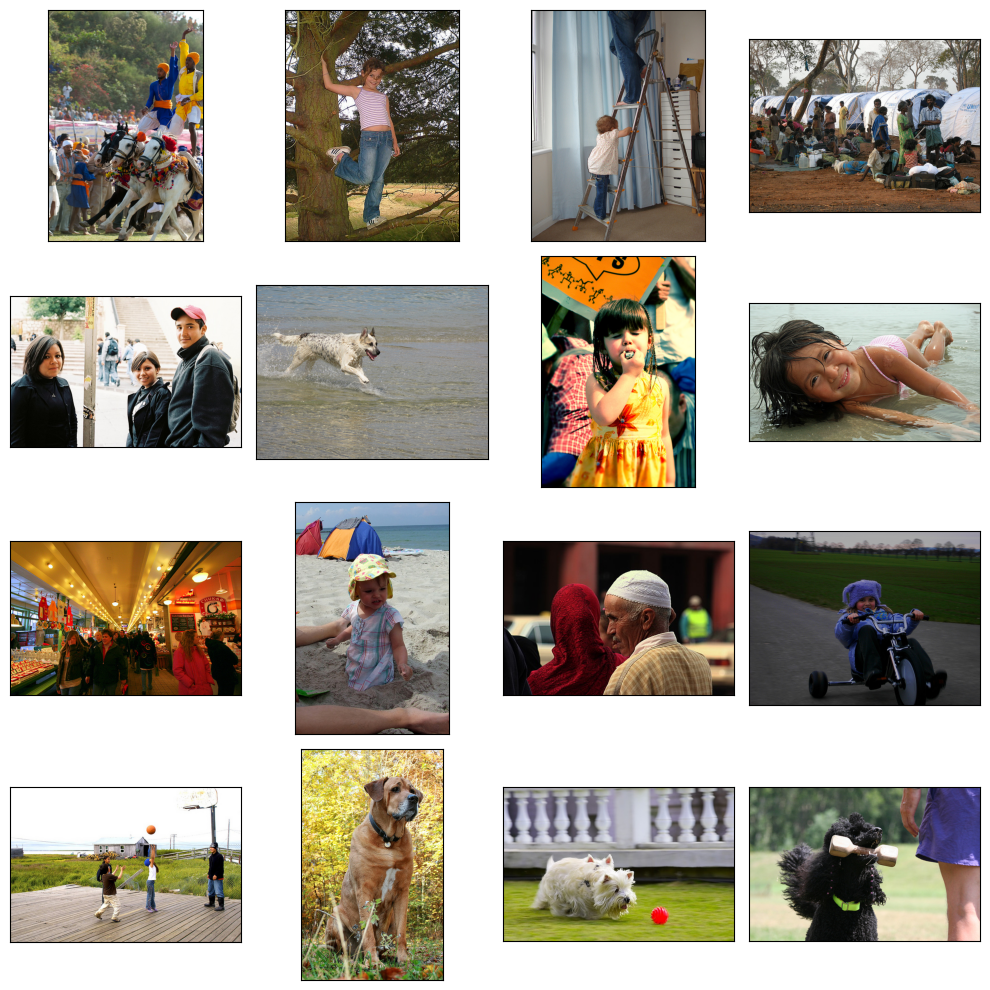

In [23]:
samples_train = list(df_train['image'].sample(8))
samples_test = list(df_queries['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Вывод 

У нас есть 1000 фото из тренировочной папки и 100 из тетсовой 

Присутсвуют экспертные оценки 5822

Оценок с краудсорсинга 47830

разработаем функцию для объединения оценок специалистов и применим её к набору данных.

В случае, если все оценки различаются, мы выполним усреднение оценок и приведем их к диапазону от 0 до 1. А если имеется несколько одинаковых оценок, мы выберем наиболее часто встречающуюся оценку.

In [24]:
def expert_aggregate(row) -> object:

    if row['first'] != row['second'] != row['third']:
        row['expert_score'] = (row['first'] + row['second'] + row['third'] - 3) / 3 / 3

    else: 
        row['expert_score'] = (max(set([row['first'], row['second'], row['third']]), key = [row['first'], row['second'], row['third']].count) - 1) / 3

    return row

df_expert = df_expert.apply(expert_aggregate, axis=1)

In [25]:
df_scores = pd.merge(df_expert, df_crowd, how='outer', on=['image', 'query_id'])

def score_aggregate(row) -> object:

    if np.isnan(row['expert_score']):
        row['score'] = row['share_pos']
    elif np.isnan(row['share_pos']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.7 + row['share_pos'] * 0.3
        
    return row

df_scores = df_scores.apply(score_aggregate, axis=1)

In [26]:
df_scores['score'].describe()

count    51323.000000
mean         0.075967
std          0.208417
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: score, dtype: float64

Добавим цели в наш df

In [27]:
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

In [28]:
to_fill = df_train[df_train['query_text'].notna()]

Заполним пропуски в описании после добавления оценок от участников.

In [29]:
def fill_text(row) -> object:

    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

df_train = df_train.apply(fill_text, axis=1)

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [31]:
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для предотвращения наличия нелегального контента мы воспользуемся текстовыми описаниями файлов.

Ранее мы определили список слов, по которым мы исключим фото из выборки

Проведем процесс очистки, токенизации и лемматизации текста, чтобы упростить поиск запросов, связанных с детьми. Мы также будем помечать фотографии в обучающем наборе, которые подлежат блокировке.

In [32]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text) -> list:

    text = re.sub('[^a-zA-Z]', ' ', text).lower() 
    text = nltk.word_tokenize(text, language = 'english') 
    text = [lemmatize.lemmatize(word) for word in text] 

    return text

def cleaning(row) -> object:

    text = get_lemmas(row['query_text'])
    if [i for i in text if i in BAN]:
        row['to_ban'] = 1
    else:
        row['to_ban'] = 0

    return row

In [33]:
df_train = df_train.apply(cleaning, axis=1)

Посмотрим на картинки, которые мы заблокировали

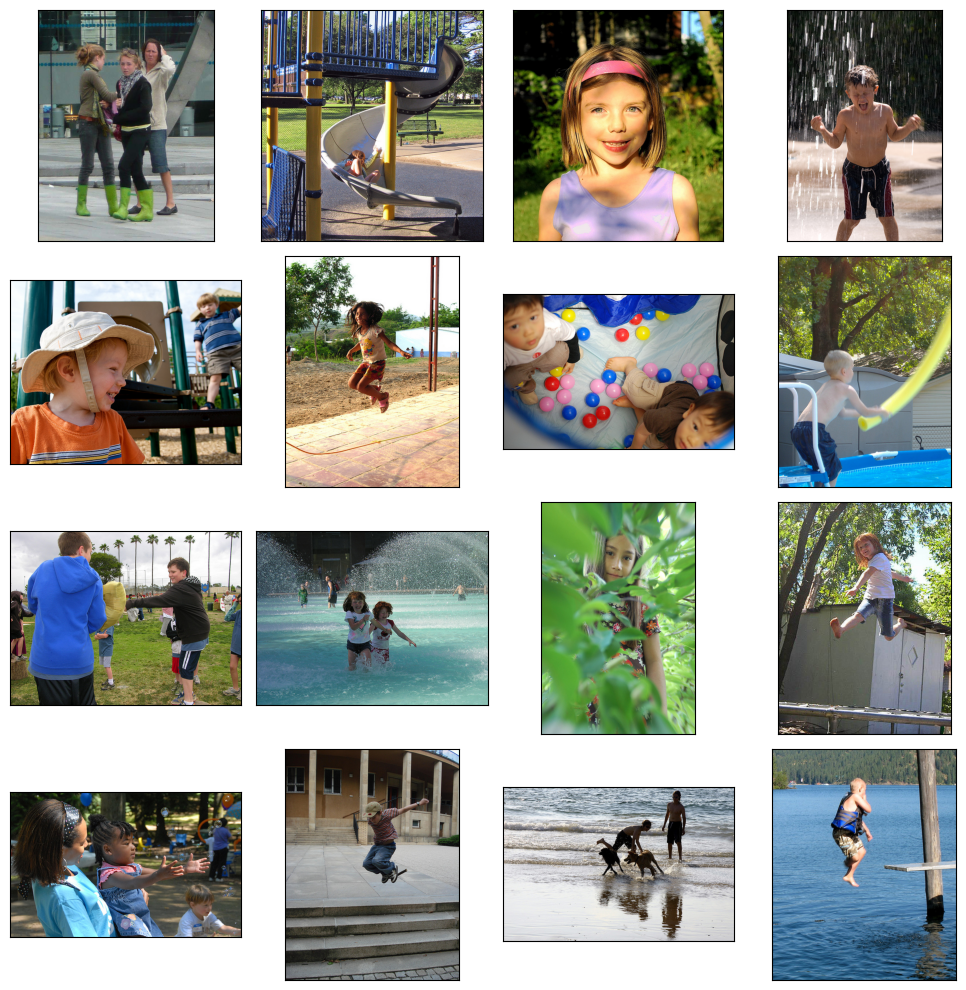

In [34]:
samples = list(df_train[df_train['to_ban'] == 1]['query_id'].sample(16))
samples = [i[:-2] for i in samples]

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вроде избавились от детей, будем считать что леди в зеленом на выпусконом в 9 классе

Удалим строки с детьми из наших данных

In [35]:
df_train.drop(df_train[df_train['to_ban'] == 1].index, inplace=True, errors='ignore')
df_train.drop(columns='to_ban', inplace=True, errors='ignore')
df_train.reset_index(inplace=True, drop=True)

In [36]:
df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
1  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
2   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
3   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
4   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                        query_text     score  
0  A man sleeps under a blanket on a city street .  0.000000  
1  A man sleeps under a blanket on a city street .  0.333333  
2  A man sleeps under a blanket on a city street .  0.233333  
3  A man sleeps under a blanket on a city street .  0.333333  
4  A man sleeps under a blanket on a city street .  0.000000

In [37]:
df_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [38]:
df_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36125 entries, 0 to 36124
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       36125 non-null  object 
 1   query_id    36125 non-null  object 
 2   query_text  36125 non-null  object 
 3   score       36125 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [40]:
df_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


## Вывод 
Убрали запрещенный контент из датасетов

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Создаем функию загрузки картинок

In [41]:
def load_train(path=PATH) -> ImageDataGenerator:
    
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=Path(path, 'train_images'),
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=SEED)
    
    return train_gen_flow

Found 36125 validated image filenames.


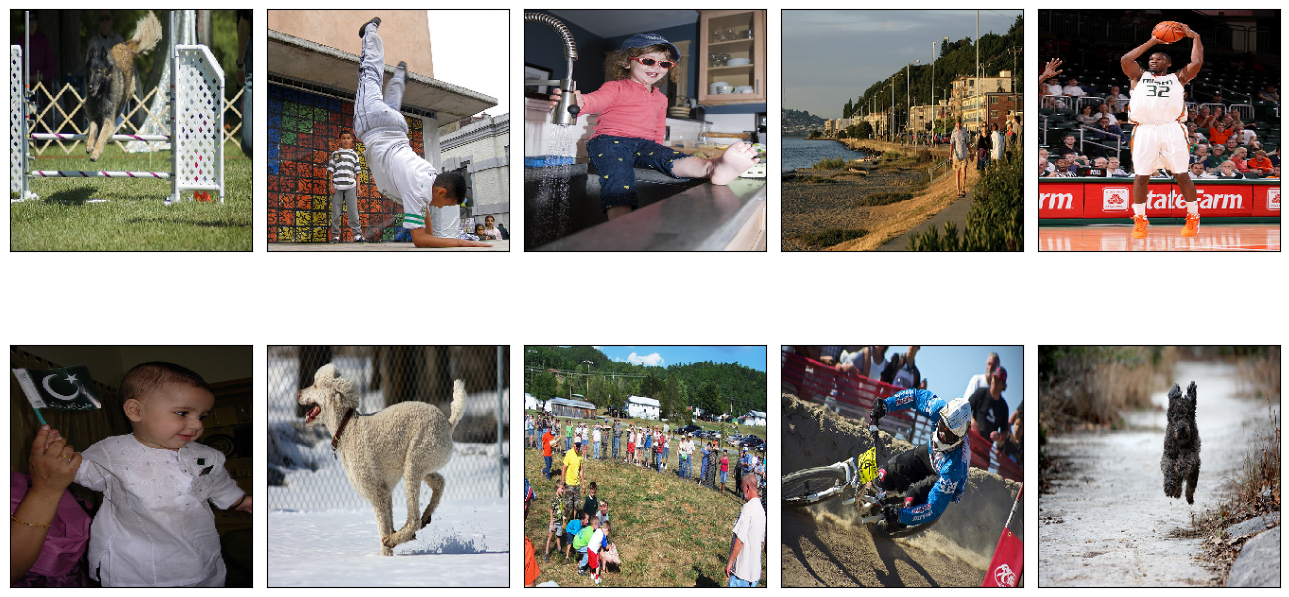

In [42]:
flow_train = load_train()
features, target = next(flow_train)

fig = plt.figure(figsize=(13,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

В выдачу попали фото с детьми, по всемй видимости из-за наличия сравнений с ними в строках с низкими оценками.

Создадим модель

In [43]:
def create_model(input_shape=(256, 256, 3)):
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

Делаем из данных вектор

In [44]:
def vectorize_pictures(model, train_data):
    
    predictions = model.predict(train_data)
    
    return predictions

Получаем вектора

In [45]:
%%time
pict_embeds = vectorize_pictures(create_model(), load_train())

Found 36125 validated image filenames.
2258/2258 [==============================] - 1623s 718ms/step
CPU times: total: 4h 3min 10s
Wall time: 27min 8s


In [46]:
print(pict_embeds.shape)

(36125, 2048)


## Вывод

Сдеалали вектора фото

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

In [47]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

Далее на очереди этап векторизации текстов. Для этой цели мы воспользуемся моделью трансформера BERT из библиотеки Keras-NLP.

Мы загрузим предобученную модель BERT base cased EN без классификационной головы.

In [48]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

embeddings = []
text = list(df_train['query_text'])
batch_size = 32

for i in tqdm(range(0, len(text), batch_size)):
    batch_text = text[i:i+batch_size]

    inputs = tokenizer(batch_text, padding=True, truncation=True, return_tensors="tf")

    outputs = bert_model(**inputs)
    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    
    embeddings.append(batch_embeddings)

embeddings = np.concatenate(embeddings, axis=0)

print("Shape of embeddings:", embeddings.shape)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

  0%|          | 0/1129 [00:00<?, ?it/s]

Shape of embeddings: (36125, 768)
CPU times: total: 1h 29min 4s
Wall time: 15min 9s


In [49]:
embeddings.shape

(36125, 768)

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [50]:
features = np.concatenate((pict_embeds, embeddings), axis=1)
features.shape

(36125, 2816)

In [51]:
target = np.array(df_train['score'])
target.shape

(36125,)

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [52]:
groups = df_train['image']
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=12345)

train_indices, test_indices = next(gss.split(X=features, y=target, groups=groups))

features_train, features_test = features[train_indices], features[test_indices]
target_train, target_test = target[train_indices], target[test_indices]

Выполним стандартизацию признаков (features) в наборе данных для обучения и тестирования

In [53]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

#### Обучим линейную регрессию

Будем использовать метрику MSE, поскольку данная метрика хорошо подходит для задач регрессии, где необходимо оценить отклонение предсказанных значений от истинных значений.

In [54]:

linear_regressor = LinearRegression()
linear_regressor.fit(features_train, target_train)

linear_predictions = linear_regressor.predict(features_test)

linear_mse = mean_squared_error(target_test, linear_predictions)
print("Linear Regression Mean Squared Error:", linear_mse)

Linear Regression Mean Squared Error: 0.0473616005454768


#### Нейронная сеть

In [55]:
model = Sequential()
model.add(Dense(64, input_dim=features_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Компиляция модели
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Обучение модели
history = model.fit(features_train, target_train, epochs=50, batch_size=32, validation_split=0.2)

# Прогнозирование на тестовых данных
nn_predictions = model.predict(features_test)

# Оценка качества модели
nn_mse = mean_squared_error(target_test, nn_predictions)
print("Neural Network Mean Squared Error:", nn_mse)

Epoch 1/50
633/633 [==============================] - 2s 3ms/step - loss: 2.1970 - val_loss: 0.0498
Epoch 2/50
633/633 [==============================] - 1s 2ms/step - loss: 0.2962 - val_loss: 0.0463
Epoch 3/50
633/633 [==============================] - 1s 2ms/step - loss: 0.1191 - val_loss: 0.0489
Epoch 4/50
633/633 [==============================] - 1s 2ms/step - loss: 0.0725 - val_loss: 0.0481
Epoch 5/50
633/633 [==============================] - 1s 2ms/step - loss: 0.0820 - val_loss: 0.0456
Epoch 6/50
633/633 [==============================] - 1s 2ms/step - loss: 0.0640 - val_loss: 0.0504
Epoch 7/50
633/633 [==============================] - 1s 2ms/step - loss: 0.0580 - val_loss: 0.0493
Epoch 8/50
633/633 [==============================] - 1s 2ms/step - loss: 0.0646 - val_loss: 0.0518
Epoch 9/50
633/633 [==============================] - 1s 2ms/step - loss: 0.0556 - val_loss: 0.0551
Epoch 10/50
633/633 [==============================] - 1s 2ms/step - loss: 0.0540 - val_loss: 0.0486

#### LinearSVR

In [56]:
from sklearn.svm import LinearSVR

linear_svr = LinearSVR(random_state=12345)
linear_svr.fit(features_train, target_train)

# Прогнозирование на тестовых данных
linear_svr_predictions = linear_svr.predict(features_test)

# Оценка качества модели
linear_svr_mse = mean_squared_error(target_test, linear_svr_predictions)
print("Linear SVR Mean Squared Error:", linear_svr_mse)

C:\Users\anon9\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVR Mean Squared Error: 0.10014238264210044


C:\Users\anon9\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [57]:
print("Linear Regression Mean Squared Error:", linear_mse)
print("Neural Network Mean Squared Error:", nn_mse)
print("Linear SVR Mean Squared Error:", linear_svr_mse)

Linear Regression Mean Squared Error: 0.0473616005454768
Neural Network Mean Squared Error: 0.04724169652406883
Linear SVR Mean Squared Error: 0.10014238264210044


### Вывод

Мы обучили 3 модели. Наилучший результат показала нейроная сеть, но и линейная регрессия не отстает

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [58]:
nn_predictions = model.predict(features_test)
nn_mse = mean_squared_error(target_test, nn_predictions)
print("Neural Network Mean Squared Error on Test Data:", nn_mse)

338/338 [==============================] - 0s 981us/step
Neural Network Mean Squared Error on Test Data: 0.04724169652406883


In [81]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = df_images,
        directory = Path(PATH, 'test_images'),
        x_col ='image',
        y_col ='score',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'input',
        seed = 12345)

Found 100 validated image filenames.


In [83]:
image_embedings = vectorize_pictures(create_model(), test_gen_flow)
image_embedings.shape

7/7 [==============================] - 4s 461ms/step


(100, 2048)

In [145]:
def txt_vec(text):
    test_embeddings = []
    batch_size = 4

    for i in notebook.tqdm(range(0, len(text), batch_size)):
        batch_text = text[i:i + batch_size]

        inputs = tokenizer(batch_text, padding=True, truncation=True, return_tensors="tf")
        outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()

        test_embeddings.extend(batch_embeddings)

    text_embeddings_test = np.concatenate(test_embeddings)
    return text_embeddings_test

In [148]:
def inference(text):
    bin_array = [i for i in get_lemmas(text) if i in BAN]
    if bin_array:
        print('-' * 100)
        print()
        print(text)
        print()
        print('#' * 77)
        s = 'This image is unavailable in your country in compliance with local laws'.upper()
        print(f'## {s} ##')
        print('#' * 77)
        print()
    else:
        text_embed = txt_vec([text])
        feature = np.concatenate((image_embedings, np.resize(text_embed, (image_embedings.shape[0], 768))), axis=1)
        feature = scaler.transform(feature)
        predictions = model.predict(feature)
        
        data = pd.concat((df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='predictions')), axis=1)
        top = list(data.sort_values(by='predictions', ascending=False)['image'].head(5))
        top_score = list(data.sort_values(by='predictions', ascending=False)['predictions'].head(5))
        
        print()
        print(text)
        print()
        
        fig = plt.figure(figsize=(15, 6))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i + 1, title=round(top_score[i], 2))
            image = Image.open(Path(PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        if text in list(df_queries['query_text']):
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            print()
        
        plt.show()
        
        print('-' * 100)
    return None

----------------------------------------------------------------------------------------------------

Young children shoot baskets in the field .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

A red haired girl making a peace sign is wearing neon green glasses and floaties and playing in the pool with other kids .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

A little girl buried in the sand .

###################

  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step

A skier coming over a snowy hill while people look on .




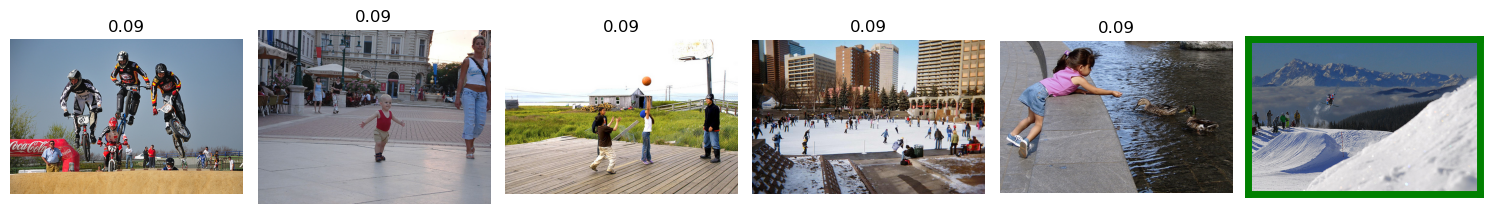

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step

Red boat marked GRAHAM races across water .




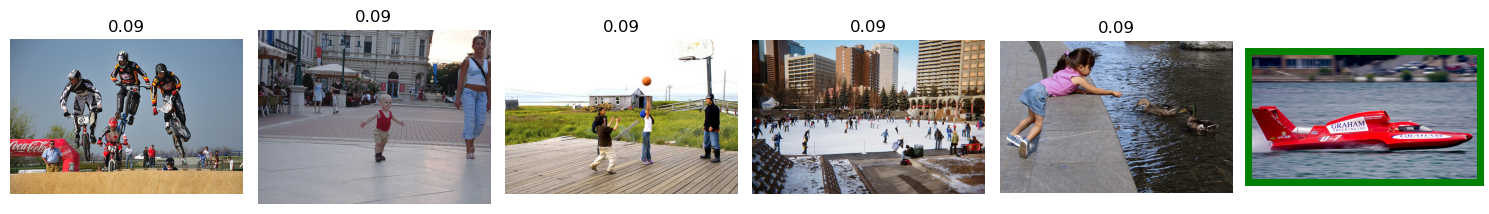

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step

A man sits on the gravel by an ocean .




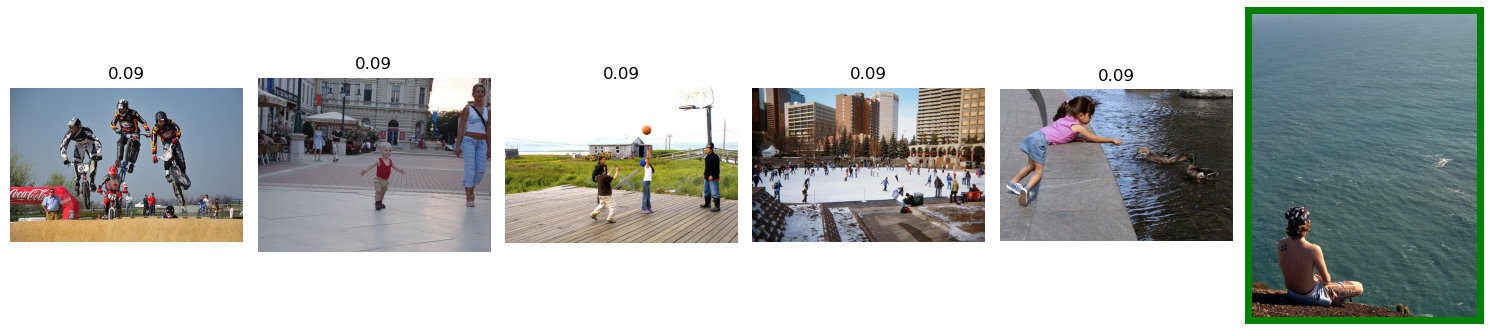

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step

A group of people playing instruments in the woods .




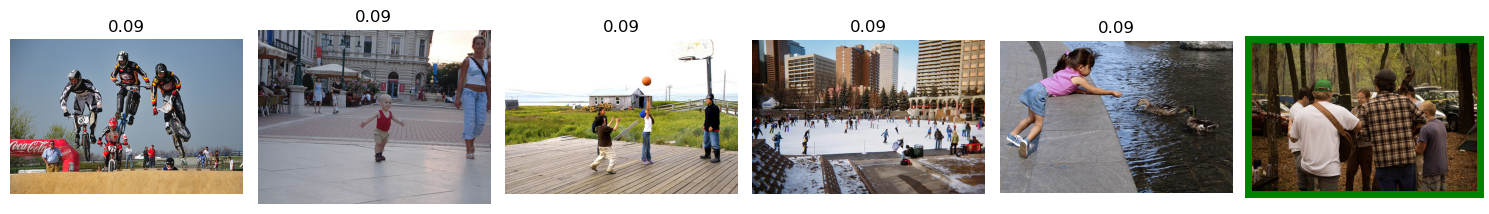

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 997us/step

A dog holds a large stick in its mouth .




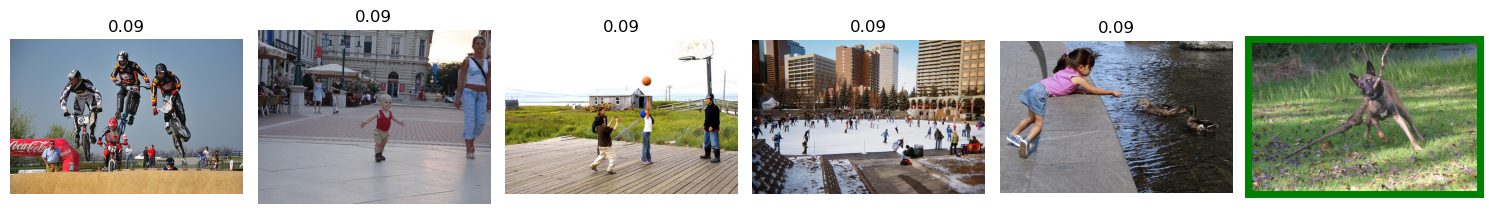

----------------------------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step

The light colored dog is running through a field .




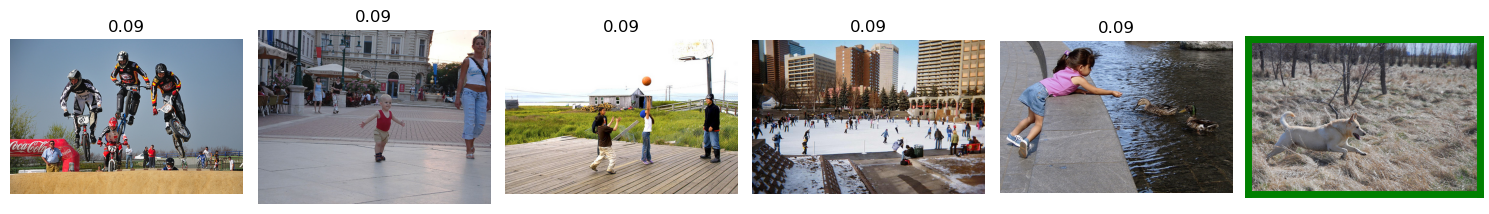

----------------------------------------------------------------------------------------------------


In [149]:
test_phrases = list(df_queries['query_text'].sample(10))
for phrase in test_phrases:
    inference(phrase)